In [2]:
# initial setup
try:
    # settings colab:
    import google.colab
    
    # si usan colab, deben cambiar el token de esta url
    #! mkdir -p ../data
    # los que usan colab deben modificar el token de esta url:
    #! wget -O ../data/properati_2017.csv https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_students_2020/master/M2/CLASE_07_Pandas_2/Data/resultado-de-encuestas-2017-2018.csv?token=AA4GFHO3EKGWGILBCV4BISC6WR6B4
    
except ModuleNotFoundError:    
    # settings local:
    %run "common/base_setup.py"

Running command `conda list`... ok
pandas=1.0.3 already installed
matplotlib=2.2.2 already installed
bokeh=2.0.0 already installed
seaborn=0.10.0 already installed
ipywidgets=7.5.1 already installed
pytest=5.3.4 already installed
chardet=3.0.4 already installed
plotly=4.6.0 already installed
Running command `conda install --yes chart-studio=1.1.0`... error
    
PackagesNotFoundError: The following packages are not available from current channels:

  - chart-studio=1.1.0

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.





## Carga Inicial del Dataset

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

import seaborn as sns
import re

from functools import partial

# Utilidades
def freq_na(df, zeros=False):
    miss      = df.isnull().sum(axis=0)
    miss_prop = miss / len(df)
    freq = pd.concat([miss, miss_prop], axis=1)
    freq.columns = ['total', 'proporcion']
    return freq if zeros else freq[freq['total'] > 0]

def show_na(df):
    # proporcion de valores NA + orden
    miss = df.isnull().sum() / len(df)
    miss = miss[miss > 0]
    miss.sort_values(inplace=True)
    # dataset
    miss = miss.to_frame()
    miss.columns = ['total']
    miss.index.names = ['variable']
    miss['variable'] = miss.index
    # plot
    sns.set(style="whitegrid", color_codes=True)
    sns.barplot(x='variable', y='total', data=miss)
    plt.xticks(rotation = 90)
    plt.show()
    
def na_columns(df):
    df.columns[df.isnull().any()]

In [4]:
# low_memorybool, default True
# Internally process the file in chunks, resulting in lower memory use while parsing, 
# but possibly mixed type inference. To ensure no mixed types either set False, 
# or specify the type with the dtype parameter. 
# Note that the entire file is read into a single DataFrame regardless, 
# use the chunksize or iterator parameter to return the data in chunks. (Only valid with C parser).
data = pd.read_csv("./data/properati_2017.csv", sep = ",", low_memory=False)

geonames = pd.read_csv("./data/AR.txt", sep = "\t", header=None, low_memory=False)
geonames = geonames[[0, 4, 5]]
geonames.rename(columns={0:'geonames_id', 4: 'gn_lat', 5: 'gn_lon'}, inplace=True)

subtes = pd.read_csv("./data/estaciones-de-subte.csv", sep = ",", low_memory=False)

data.shape

(121220, 26)

In [5]:
data.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

In [6]:
data.dtypes

Unnamed: 0                      int64
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: objec

In [7]:
# categoricals
data["operation"]     = data["operation"].astype('category')
data["property_type"] = data["property_type"].astype('category')
data["country_name"]  = data["country_name"].astype('category')
data["state_name"]    = data["state_name"].astype('category')

# normalizaciones
regex = re.compile(r'\s+')
fformat = lambda x: regex.sub(' ', str(x)).strip().lower()
data['description'] = data['description'].apply(fformat)
data['title']       = data['title'].apply(fformat)

# Distribucion NA - Fase 0 Inicial
data.dropna(how='all', inplace=True)
freq_na(data)

,total,proporcion
place_name,23,0.000190
geonames_id,18717,0.154405
lat-lon,51550,0.425260
lat,51550,0.425260
lon,51550,0.425260
price,20410,0.168372
currency,20411,0.168380
price_aprox_local_currency,20410,0.168372
price_aprox_usd,20410,0.168372
surface_total_in_m2,39328,0.324435


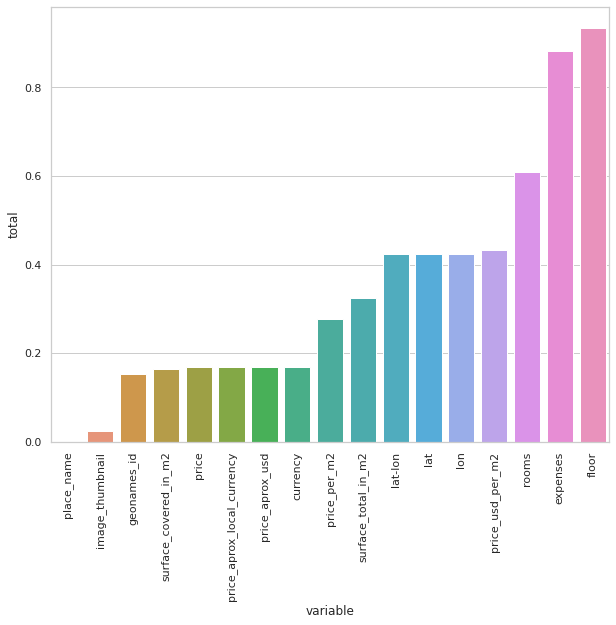

In [8]:
show_na(data)

## Tratamiento NA

In [9]:
# Registros falopa
data = data[~data['description'].str.contains('edificio: gala x', regex=False)]
data = data[~data['title'].str.contains('111.111 -', regex=False)] 

In [10]:
# NA - place_name
na_place_name_mask = data["place_name"].isna()

data['place_name'] = data['place_name'].fillna("Tigre").astype('category')

print("NA place_name (0): {0}".format(na_place_name_mask.sum()))
print("NA place_name (1): {0}".format(data["place_name"].isna().sum()))

NA place_name (0): 23
NA place_name (1): 0


In [11]:
# NA - lat/lon
na_lat_mask = data["lat"].isna()
na_lon_mask = data["lon"].isna()

data = pd.merge(data, geonames, on='geonames_id', how='left', left_index=True)
data['lat'].fillna(data['gn_lat'], inplace=True)
data['lon'].fillna(data['gn_lon'], inplace=True)

data.drop(['gn_lat', 'gn_lon'], axis=1, inplace=True)

print("NA (lat, lon) (0): ({0}, {1})".format(na_lat_mask.sum(), na_lon_mask.sum()))
print("NA (lat, lon) (1): ({0}, {1})".format(data["lat"].isna().sum(), data["lon"].isna().sum()))

NA (lat, lon) (0): (51529, 51529)
NA (lat, lon) (1): (8346, 8346)


In [12]:
# NA - rooms
def get_rooms_from_text(text):
    if text is not np.nan:
        regex = r'([0-9]+)\s+(amb\s|amb\.|ambiente)'
        m = re.search(regex, text, re.I)
        if m is not None:
            return np.int(m.group(1))
    return np.nan

na_rooms_mask = data["rooms"].isna()

data['rooms'].fillna(
    data['title'].map(get_rooms_from_text),
    inplace=True)

data['rooms'].fillna(
    data['description'].map(get_rooms_from_text),
    inplace=True)

print("NA rooms (0): {0}".format(na_rooms_mask.sum()))
print("NA rooms (1): {0}".format(data["rooms"].isna().sum()))

NA rooms (0): 73830
NA rooms (1): 52531


In [13]:
def get_reg_from_text(text,reg):
    if text is not np.nan:
        regex = reg#r'parr'
        m = re.search(regex, text,re.IGNORECASE)
        if m is not None:
            return 1
    return 0

data['parrilla'] = data['description'].map(lambda x : get_reg_from_text(x,'parr|asador'))
print("Ocurrencias de parrillas encontradas: {0}".format(data['parrilla'].sum()))
data['quincho'] = data['description'].map(lambda x : get_reg_from_text(x,'quincho'))
print("Ocurrencias de quinchos  encontradas: {0}".format(data['quincho'].sum()))
data['balcon'] = data['description'].map(lambda x : get_reg_from_text(x,'balc'))
print("Ocurrencias de balcones encontrados: {0}".format(data['balcon'].sum()))
data['cochera'] = data['description'].map(lambda x : get_reg_from_text(x,'garag|coche'))
print("Ocurrencias de cocheras encontradas: {0}".format(data['cochera'].sum()))
data['patio'] = data['description'].map(lambda x : get_reg_from_text(x,'pati|jard'))
print("Ocurrencias de patios encontrados: {0}".format(data['patio'].sum()))
#existen muchos anuncios que utilizan el termino pileta en la descripcion para referirse a el fregadero
data['piscina'] = data['description'].map(lambda x : get_reg_from_text(x,'pisc'))
print("Ocurrencias de piscinas encontradas: {0}".format(data['piscina'].sum()))
#veamos la cantidad de amenities por unidad
data['amenities'] = data['parrilla'] + data['quincho'] + data['balcon'] + data['cochera'] + data['patio'] + data['piscina']

Ocurrencias de parrillas encontradas: 40894
Ocurrencias de quinchos  encontradas: 13094
Ocurrencias de balcones encontrados: 44698
Ocurrencias de cocheras encontradas: 51809
Ocurrencias de patios encontrados: 36278
Ocurrencias de piscinas encontradas: 15250


In [14]:
# NA - floor
def get_floor_from_text(text):
    if text is not np.nan:
        if 'plante baja' in text:
            return 0
        regex = r'(1°|2°|3°|4°|5°|6°|2do|3er|primer|segundo|tercer)\spiso'
        m = re.search(regex, text, re.I)
        if m is not None:
            piso = m.group(1).lower()
            if piso in ['1°', 'primer']:
                return 1
            elif piso in ['2°', '2do', 'segundo']:
                return 2
            elif piso in ['3°', '3er', 'tercer']:
                return 3
            else:
                return np.int(piso.replace('°', ''))
    return np.nan

na_floor_mask = data["floor"].isna()

data['floor'].fillna(
    data['title'].map(get_floor_from_text),
    inplace=True)

data['floor'].fillna(
    data['description'].map(get_floor_from_text),
    inplace=True)

print("NA floor (0): {0}".format(na_floor_mask.sum()))
print("NA floor (1): {0}".format(data["floor"].isna().sum()))

NA floor (0): 113298
NA floor (1): 106540


In [15]:
# NA - m2 cubiertos
def get_coveredm2_from_text(text):
    if not pd.isnull(text):
        regex = [
            r'(\d[0-9\.,]+)\s+m2\s+cub',
            r'metros\s+cubiertos\s*:?(\d[0-9\.,]+)',
            r'superficie\sedificada\s*:?\s*(\d[0-9\.,]+)',
            r'sup\.\scub\s*:?\s*(\d[0-9\.,]+)',
            r'sup\.\scubierta\s*:?\s*(\d[0-9\.,]+)',
            r'superficie\s+cubierta\s*:?\s*(\d[0-9\.,]+)',
        ]
        for pattern in regex:
            m = re.search(pattern, text, re.I)
            if m is not None:
                sup = m.group(1).strip(',')
                sup = sup.replace('.', '').replace(',', '.')
                if sup == '':
                    return np.nan
                return np.int(float(sup))
    return np.nan

na_surface_covered_mask = data["surface_covered_in_m2"].isna()

data.loc[data['surface_covered_in_m2'] == 1, 'surface_covered_in_m2'] = np.nan

data['surface_covered_in_m2'].fillna(
    data['description'].map(get_coveredm2_from_text),
    inplace=True)

print("NA surface_covered_in_m2 (0): {0}".format(na_surface_covered_mask.sum()))
print("NA surface_covered_in_m2 (1): {0}".format(data["surface_covered_in_m2"].isna().sum()))

NA surface_covered_in_m2 (0): 19907
NA surface_covered_in_m2 (1): 19731


In [16]:
# NA - m2 totales
def get_totalm2_from_text(text):
    if not pd.isnull(text):
        regex = [
            r'(\d[0-9\.,]+)\s+m2\s+tot',
            r'metros\s+totales\s*:?\s*(\d[0-9\.,]+)',
            r'(\d[0-9\.,]+)\smtrs\stot',
            r'sup\.?\s+terreno\s*:?\s*(\d[0-9\.,]+)',
            r'sup\.?\s+total\s*:?\s*(\d[0-9\.,]+)',
            r'sup\.?\s+total\s+terreno\s*:?\s*(\d[0-9\.,]+)',
            r'sup\.?\s+total\s+del\s+terreno\s*:?\s*(\d[0-9\.,]+)',
            r'superficie\s+terreno\s*:?\s*(\d[0-9\.,]+)',
            r'superficie\s+total\s*:?\s*(\d[0-9\.,]+)',
            r'terreno\s*:?\s*(\d[0-9\.,]+)\s*mt',
            r'terreno\s*:?\s*(\d[0-9\.,]+),',
            r'(\d[0-9\.,]+)\s+m2\s+de\s+terreno',
            r'(\d[0-9\.,]+)\s+mts?\s+de\s+terreno',
        ]
        for pattern in regex:
            m = re.search(pattern, text, re.I)
            if m is not None:
                sup = m.group(1)
                sup = sup.replace('.', '').replace(',', '.')
                return np.nan if sup == '' else np.int(float(sup))
    return np.nan

na_surface_total_mask = data["surface_total_in_m2"].isna()

data['surface_total_in_m2'].fillna(
    data['description'].map(get_totalm2_from_text),
    inplace=True)

print("NA surface_total_in_m2 (0): {0}".format(na_surface_total_mask.sum()))
print("NA surface_total_in_m2 (1): {0}".format(data["surface_total_in_m2"].isna().sum()))

NA surface_total_in_m2 (0): 39328
NA surface_total_in_m2 (1): 38059


In [17]:
# NA - price/currency
def get_price_from_title(text):
    regex = r'^\s*(\$|u\$d|usd)\s*([0-9\.,]+).+en\sventa'
    m = re.search(regex, text, re.I)
    if m is None:
        return np.nan, np.nan
    currency = 'ARS' if m.group(1) == '$' else 'USD'
    price    = np.float64(m.group(2).replace('.', '').replace(',', '.'))
    return currency, price

def get_price_from_description(text):
    if text is not np.nan:    
        regex = r'(vendo\scasa|valor\sde\sventa|valor:|vendo|valor|precio\ses\sde|precio\sde)\s+(\$|u\$d|usd)\s*([0-9\.,]+)'
        m = re.search(regex, text, re.I)
        if m is not None:
            currency = 'ARS' if m.group(2) == '$' else 'USD'
            price    = m.group(3).strip('.')
            if len(price) > 0:
                return currency, np.float64(price.replace('.', '').replace(',', '.'))
    return np.nan, np.nan

na_price_mask    = data["price"].isna()
na_currency_mask = data["currency"].isna()

data['tcurrency_tmp'], data['tprice_tmp'] = zip(*data['title'].map(get_price_from_title))
data['dcurrency_tmp'], data['dprice_tmp'] = zip(*data['description'].map(get_price_from_description))

data['price'].fillna(data['tprice_tmp'], inplace=True)
data['price'].fillna(data['dprice_tmp'], inplace=True)
data['currency'].fillna(data['tcurrency_tmp'], inplace=True)
data['currency'].fillna(data['dcurrency_tmp'], inplace=True)

data.drop(['tprice_tmp', 'dprice_tmp', 'tcurrency_tmp', 'dcurrency_tmp'], axis=1, inplace=True)

print("NA (price, currency) (0): ({0}, {1})".format(na_price_mask.sum(), na_currency_mask.sum()))
print("NA (price, currency) (1): ({0}, {1})".format(data["price"].isna().sum(), data["currency"].isna().sum()))

NA (price, currency) (0): (20407, 20408)
NA (price, currency) (1): (17463, 17464)


In [18]:
# dollar value
na_price_aprox_mask = data['price_aprox_usd'].isna() & data['price_aprox_local_currency'].isna()
price_aprox  = data.loc[~na_price_aprox_mask, ['price_aprox_usd', 'price_aprox_local_currency']]

na_price_aprox_gt0_mask = (price_aprox['price_aprox_usd'] > 0) & \
    (price_aprox['price_aprox_local_currency'] > 0)
price_aprox  = price_aprox[na_price_aprox_gt0_mask]

dollar_serie = price_aprox['price_aprox_local_currency'] / price_aprox['price_aprox_usd']
dollar = np.mean(dollar_serie)

print("Valor del Dolar: {0}".format(dollar))

Valor del Dolar: 17.644499988445965


In [19]:
# computo NA usando otras columnas
def fill_from_row(r, dollar):
    # fill prices aprox.
    if pd.notna(r.price):
        if pd.isna(r.price_aprox_usd):
            r.price_aprox_usd = r.price if r.currency == 'USD' else r.price / dollar
        if pd.isna(r.price_aprox_local_currency):
            r.price_aprox_local_currency = r.price if r.currency == 'ARS' else r.price * dollar
    # fill surface_total for apartment
    if r.property_type == 'apartment':
        if pd.isna(r.surface_total_in_m2) and pd.notna(r.surface_covered_in_m2):
            r.surface_total_in_m2 = r.surface_covered_in_m2
    # fill prices m2
    if pd.isna(r.price_usd_per_m2):
        if pd.notna(r.price_aprox_usd) and pd.notna(r.surface_total_in_m2) and r.surface_total_in_m2 > 0:
            r.price_usd_per_m2 = r.price_aprox_usd / r.surface_total_in_m2
        elif pd.notna(r.price_per_m2):
            r.price_usd_per_m2 = r.price_per_m2 / dollar
    if pd.isna(r.price_per_m2):
        if pd.notna(r.price_usd_per_m2):
            r.price_per_m2 = r.price_usd_per_m2 * dollar
        elif pd.notna(r.price_aprox_local_currency) and pd.notna(r.surface_total_in_m2) and r.surface_total_in_m2 > 0:
            r.price_per_m2 = r.price_aprox_local_currency / r.surface_total_in_m2
    # fill surface total
    if pd.isna(r.surface_total_in_m2):
        if pd.notna(r.price_aprox_usd) and pd.notna(r.price_usd_per_m2):
            r.surface_total_in_m2 = r.price_aprox_usd / r.price_usd_per_m2
        elif pd.notna(r.price_aprox_local_currency) and pd.notna(r.price_per_m2):
            r.surface_total_in_m2 = r.price_aprox_local_currency / r.price_per_m2
    return r

na_price_aprox_usd_mask            = data["price_aprox_usd"].isna()
na_price_aprox_local_currency_mask = data["price_aprox_local_currency"].isna()
na_price_usd_per_m2_mask           = data['price_usd_per_m2'].isna()
na_price_per_m2_mask               = data['price_per_m2'].isna()
na_surface_total_mask              = data['surface_total_in_m2'].isna()

data = data.apply(partial(fill_from_row, dollar=dollar), axis=1)

print("NA (price_usd, price_local) (0): ({0}, {1})".format(
    na_price_aprox_usd_mask.sum(), na_price_aprox_local_currency_mask.sum()))
print("NA (price_usd, price_local) (1): ({0}, {1})".format(
    data["price_aprox_usd"].isna().sum(), data["price_aprox_local_currency"].isna().sum()))
print("NA (price_usd_per_m2, price_per_m2) (0): ({0}, {1})".format(
    na_price_usd_per_m2_mask.sum(), na_price_per_m2_mask.sum()))
print("NA (price_usd_per_m2, price_per_m2) (1): ({0}, {1})".format(
    data["price_usd_per_m2"].isna().sum(), data["price_per_m2"].isna().sum()))
print("NA surface_total_in_m2 (0): {0}".format(na_surface_total_mask.sum()))
print("NA surface_total_in_m2 (1): {0}".format(data["surface_total_in_m2"].isna().sum()))

NA (price_usd, price_local) (0): (20407, 20407)
NA (price_usd, price_local) (1): (17463, 17463)
NA (price_usd_per_m2, price_per_m2) (0): (52600, 33559)
NA (price_usd_per_m2, price_per_m2) (1): (25624, 25624)
NA surface_total_in_m2 (0): 38059
NA surface_total_in_m2 (1): 13551


In [20]:
# Eliminamos columnas
data.drop(['expenses', 'lat-lon', 'image_thumbnail',
           'place_with_parent_names', 'properati_url',
           'price', 'currency'], axis=1, inplace=True)

# Distribución NA - Fase 1 con Faltantes
freq_na(data)

,total,proporcion
geonames_id,18717,0.154435
lat,8346,0.068863
lon,8346,0.068863
price_aprox_local_currency,17463,0.144088
price_aprox_usd,17463,0.144088
surface_total_in_m2,13551,0.111810
surface_covered_in_m2,19731,0.162801
price_usd_per_m2,25624,0.211424
price_per_m2,25624,0.211424
floor,106540,0.879065


In [21]:
data.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'country_name', 'state_name', 'geonames_id', 'lat', 'lon',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'description', 'title', 'parrilla', 'quincho', 'balcon',
       'cochera', 'patio', 'piscina', 'amenities'],
      dtype='object')

In [22]:
# Rename/re-order
new_columns = {
    'Unnamed: 0'                : 'id',                  #0
    'surface_total_in_m2'       : 'superficie_total',    #11
    'surface_covered_in_m2'     : 'superficie_cubierta', #12
    'price_aprox_local_currency': 'precio_ars',    #9
    'price_aprox_usd'           : 'precio_usd',    #10
    'price_per_m2'              : 'precio_m2_ars', #14
    'price_usd_per_m2'          : 'precio_m2_usd', #13
    'rooms'                     : 'ambientes', #16
    'lon'                       : 'lng',       #8
    'floor'                     : 'piso',      #15
    'geonames_id'               : 'geoid',     #6
    'place_name'                : 'localidad', #3
    'state_name'                : 'estado',    #5
    'country_name'              : 'pais',      #4
    'property_type'             : 'tipo',      #2
    'operation'                 : 'op',        #1
    'description'               : 'descripcion', #17
    'title'                     : 'titulo',    #18
    #'lat'                      : 'lat',       #7
    'parrilla'                  : 'parrilla',  #19
    'quincho'                   : 'quincho',   #20
    'balcon'                    : 'balcon',    #21
    'cochera'                   : 'cochera',   #22
    'patio'                     : 'patio',     #23
    'piscina'                   : 'piscina',   #24
    'amenities'                 : 'amenities', #25
}
data.rename(columns=new_columns, inplace=True)

new_order = [0, 1, 2, 4, 5, 3, 6, 7, 8, 10, 9, 13, 14, 11, 12, 15, 16, 18, 17, 19, 20, 21, 22, 23, 24, 25]
data = data[data.columns[new_order]]

data.head(5)

,id,op,tipo,pais,estado,localidad,geoid,lat,lng,precio_usd,...,ambientes,titulo,descripcion,parrilla,quincho,balcon,cochera,patio,piscina,amenities
3577.0,0,sell,PH,Argentina,Capital Federal,Mataderos,3430787.0,-34.661824,-58.508839,62000.0,...,2.0,2 amb tipo casa sin expensas en pb,"2 ambientes tipo casa planta baja por pasillo,...",0,0,0,0,1,0,1
4827.0,1,sell,apartment,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,3432039.0,-34.903883,-57.964330,150000.0,...,NaN,venta depto 2 dorm. a estrenar 7 e/ 36 y 37,venta de departamento en décimo piso al frente...,0,0,1,1,0,0,2
3577.0,2,sell,apartment,Argentina,Capital Federal,Mataderos,3430787.0,-34.652262,-58.522982,72000.0,...,2.0,2 amb 3er piso con ascensor apto credito,2 ambientes 3er piso lateral living comedor am...,0,0,0,0,0,0,0
4122.0,3,sell,PH,Argentina,Capital Federal,Liniers,3431333.0,-34.647797,-58.516424,95000.0,...,3.0,ph 3 amb. cfte. reciclado,ph 3 ambientes con patio. hay 3 deptos en lote...,0,0,0,0,1,0,1
NaN,4,sell,apartment,Argentina,Buenos Aires Costa Atlántica,Centro,3435548.0,-38.002626,-57.549447,64000.0,...,2.0,depto 2 amb al contrafrente zona centro/plaza ...,departamento con fantástica iluminación natura...,0,0,0,0,0,0,0


In [23]:
# Clustering - Agregamos nueva columna 'estado' con la categoría Otros que agrupe a todos los chiquitos.
counts = data.groupby('estado').size()
groups = [name for name, value in counts.items() if value > 999]
data['grupo'] = [value if value in groups else 'Otros' for value in data['estado']]
data['grupo'] = data['grupo'].astype('category')

## Tratamiento de Outliers

In [24]:
def update(df, id, st, sc=None):
    price   = list(df.loc[df['id'] == id, 'precio_usd'])[0]
    pricem2 = price / st
    if sc is None:
        df.loc[df['id'] == id, ['superficie_total', 'precio_m2_usd']] = [st, pricem2]
    else:
        df.loc[df['id'] == id, ['superficie_total', 'superficie_cubierta', 'precio_m2_usd']] = [st, sc, pricem2]
    if pricem2 > 15000:
        print(id, st, pricem2)

def update_price(df, id, price):
    surface = list(df.loc[df['id'] == id, 'superficie_total'])[0]
    pricem2 = price / surface
    df.loc[df['id'] == id, ['precio_usd', 'precio_m2_usd']] = [price, pricem2]
    if pricem2 > 15000:
        print(id, price, pricem2)
        
def mask_condition(state_name, df, max_price, keep_if_in=[], reverse=False):
    mask = (df['estado'] == state_name) & (df['precio_m2_usd'] > max_price)
    if len(keep_if_in) > 0:
        mask = mask & ~df['id'].isin(keep_if_in)
    return mask if not reverse else ~mask

def dropables(df, state_name, max_price, min_price=0, keep_if_in=[]):
    statemask = df['estado'] == state_name
    pricemask = (df['precio_m2_usd'] > max_price) if min_price == 0 else \
        (df['precio_m2_usd'] > max_price) | (df['precio_m2_usd'] < min_price)
    dropmask = statemask & pricemask if len(keep_if_in) == 0 else \
        statemask & pricemask & ~df['id'].isin(keep_if_in)
    return [] if len(df) == 0 else list(df[dropmask]['id'])
########################################################################################
trash = []
########################################################################################
############ precio_usd <= precio_m2_usd
############ [10528, 41061, 41574, 47586, 49274, 53324, 55181, 67746]
trash += [10528, 41574, 47586, 49274, 53324, 55181]
update(data, 41061, 1240)
update(data, 67746, 1300, 220)
############ precio_usd == 1 => 241
update_price(data, 263, 240000)
update_price(data, 7587, 250000)
update(data, 7587, 780)
update_price(data, 9121, 270000)
update(data, 9121, 594)
update_price(data, 12918, 120000)
update(data, 12918, 65)
update_price(data, 55630, 120000)
update(data, 55630, 169)
precio_usd_eq_1 = list(data.loc[data['precio_usd'] == 1, 'id'])
trash += list(filter(lambda x: not (x in [263, 7587, 9121, 12918, 55630]), precio_usd_eq_1))
############ precio_usd < 5000 => 121
update_price(data, 2246, 299200)
update_price(data, 2281, 118800)
update_price(data, 2283, 111800)
update_price(data, 3971, 88000)
update_price(data, 2278, 77000)
precio_usd_lt_5000 = list(data.loc[data['precio_usd'] < 5000, 'id'])
trash += list(filter(lambda x: not (x in [2246, 2281, 2283, 3971, 2278]), precio_usd_lt_5000))
############ TUCUMAN
update_price(data, 1766, 3000000  / dollar)
update_price(data, 61349, 2500000 / dollar)
update_price(data, 61353, 500000  / dollar)
update_price(data, 61354, 3300000 / dollar)
update_price(data, 61355, 1300000 / dollar)
update_price(data, 62548, 1600000 / dollar)
update_price(data, 83818, 1473295 / dollar)
trash += dropables(data, 'Tucumán', 10000) + [1791, 1815, 1736, 1767, 1780, 84347]
############ RIO NEGRO
update_price(data, 1922, 360000)
update_price(data, 23339, 1785000 / dollar)
update(data, 23339, 61.65, 51.81)
update_price(data, 27106, 450000)
update(data, 33039, 132, 132)
update(data, 52268, 71)
update(data, 107137, 320)
update(data, 898, 200)
update(data, 10364, 693)
update(data, 15127, 2239)
update(data, 15906, 43)
update(data, 17064, 98.71, 98.71)
update(data, 17073, 35.47, 35.47)
update(data, 19118, 262, 45)
update(data, 21562, 182)
update(data, 19401, 3093, 201)
############ MISIONES
update(data, 14374, 200)
update(data, 63886, 400)
update(data, 38798, 107)
update(data, 38817, 432)
update(data, 41204, 375, 85)
update(data, 48617, 364.8)
update(data, 59127, 124.2)
trash += dropables(data, 'Misiones', 3000, 110, [
    14374, 63886, 38798, 38817, 41204, 48617, 59127,
])
############ SANTA FE
update_price(data, 25565, 690000 / dollar)
update_price(data, 6720, 2545000 / dollar)
update(data, 6720, 58.91)
update(data, 4917, 1032)
update(data, 102379, 76, 36)
trash += dropables(data, 'Santa Fe', 5000, 100, [
    25565, 102379, 4917, 9230, 25295, 30992, 100514,
])
############ SALTA
update(data, 11239, 600)
update_price(data, 25163, 2800000 / dollar)
update_price(data, 25343, 2850000 / dollar)
update_price(data, 25561, 1100000 / dollar)
update_price(data, 26619, 2500000 / dollar)
update_price(data, 26737, 2800000 / dollar)
update_price(data, 26738, 2600000 / dollar)
update(data, 59441, 600, 130)
update(data, 59442, 800, 110)
trash += dropables(data, 'Salta', 3000, 100, [
    11239, 25163, 25343, 25561, 26619, 26737, 26738, 59441, 59442,
])
############ MENDOZA
update_price(data, 24831, 700000 / dollar)
update_price(data, 26874, 1200000 / dollar)
trash += dropables(data, 'Mendoza', 3000, 0, [24831, 26874])
############ ENTRE RIOS
update_price(data, 26831, 1250000 / dollar)
update_price(data, 108996, 1500000 / dollar)
############ NEUQUEN
update(data, 39054, 150, 93.76)
trash += dropables(data, 'Neuquén', 3000, 100, [39054, 61373, 61521, 65398])
############ CORDOBA
update_price(data, 39978, 165000)
update_price(data, 91428, 147000)
update(data, 91428, 800, 200)
update_price(data, 91289, 160000)
update(data, 91289, 770, 190)
update(data, 115705, 6250, 200)
update(data, 115819, 245.43, 170)
update(data, 57742, 800, 190)
trash += dropables(data, 'Córdoba', 5000, 100, [
    72354, 39978, 91428, 91289, 115705, 115819, 57742,
])
############ SAN LUIS
update_price(data, 25030, 4000000 / dollar)
update_price(data, 25049, 2300000 / dollar)
update_price(data, 25051, 2600000 / dollar)
update(data, 25051, 300, 201)
update_price(data, 25353, 2800000 / dollar)
update_price(data, 25357, 700000 / dollar)
update_price(data, 25710, 1550000 / dollar)
update_price(data, 37212, 2300000 / dollar)
update_price(data, 40946, 1700000 / dollar)
update_price(data, 40947, 1600000 / dollar)
update_price(data, 51777, 1700000 / dollar)
update_price(data, 25074, 450000 / dollar)
update_price(data, 25981, 650000 / dollar)
update_price(data, 25982, 750000 / dollar)
update_price(data, 40610, 1500000 / dollar)
update_price(data, 89902, 250000 / dollar)
update_price(data, 92251, 135000 / dollar)
update(data, 92251, 85.40, 65.9)
update_price(data, 92284, 135000 / dollar)
update(data, 92284, 83.95, 66.57)
update_price(data, 92267, 135000 / dollar)
update(data, 92267, 85.40, 65.9)
############ BUENOS AIRES INTERIOR
update(data, 41655, 4600, 300)
update(data, 45533, 1000)
update(data, 60838, 870)
update_price(data, 79134, 174230)
update_price(data, 79124, 120620)
update_price(data, 70817, 96000)
trash += dropables(data, 'Buenos Aires Interior', 3000, 100, [
    41655, 45533, 60838, 79134, 79124, 70817, 93429,
])
############ BUENOS AIRES COSTA ATLANTICA
update_price(data, 1424, 180000)
update(data, 24589, 73, 16)
update(data, 11096, 130)
update(data, 58234, 71.89, 54.7)
update(data, 97096, 87)
trash += [12625, 24580, 35966, 37615, 41539, 43221, 49246, 50460, 67898, 94838, 120124]
############ BUENOS AIRES ZONA SUR
update(data, 78243, 90.22)
update(data, 58948, 132, 92)
update(data, 58398, 236)
update(data, 94342, 188.68)
update(data, 74913, 72.4)
update(data, 74957, 72.4)
update(data, 95574, 381, 220)
update(data, 75360, 123, 87)
update(data, 58062, 9718)
update(data, 12306, 7600, 70)
update(data, 73523, 112)
update(data, 7104, 235, 175)
update(data, 7665, 1200)
update(data, 8263, 229)
update(data, 8501, 850)
update(data, 8606, 850)
update(data, 9228, 145)
update(data, 9422, 216.5)
update(data, 10365, 1800)
update(data, 10368, 135)
update(data, 10991, 139)
update(data, 11632, 134)
update(data, 13439, 228.94)
update(data, 13966, 300)
update(data, 15842, 850)
update(data, 15916, 664)
update(data, 15918, 59)
update(data, 15919, 50)
update(data, 16265, 280)
update(data, 16685, 570)
update(data, 16686, 201)
update(data, 17039, 335)
update(data, 19422, 286)
update(data, 20226, 228)
update(data, 20850, 83.72, 65.72)
update(data, 21054, 2850)
update(data, 22055, 800)
update(data, 22056, 300)
update(data, 22853, 325)
update(data, 23431, 225)
update(data, 23452, 50)
update(data, 23519, 200)
update(data, 24007, 450)
update(data, 24021, 83.46, 78.51)
update(data, 27393, 420)
update(data, 27992, 900)
update(data, 28076, 52)
update(data, 28452, 55)
update(data, 28588, 211)
update(data, 30433, 235)
update(data, 30517, 952)
update(data, 31033, 1100)
update(data, 32250, 2750)
update(data, 32391, 283.5)
update(data, 33046, 420)
update(data, 33493, 1380)
update(data, 35522, 225)
update(data, 35555, 809)
update(data, 35949, 1630)
trash += dropables(data, 'Bs.As. G.B.A. Zona Sur', 4000, 100, [
    78243, 58948, 58398, 94342, 74913, 74957, 95574, 75360, 58062, 12306, 73523,
    7104, 7665, 8263, 8501, 8606, 9228, 9422, 10365, 10368, 10991, 11632, 13439, 
    13966, 15842, 15916, 15918, 15919, 16265, 16685, 16686, 17039, 19422, 20226,
    20850, 21054, 22055, 22056, 22853, 23431, 23452, 23519, 24007, 24021, 27393,
    27992, 28076, 28452, 28588, 30433, 30517, 31033, 32250, 32391, 33046, 33493,
    35522, 35555, 35949
])
############ BUENOS AIRES ZONA NORTE
update_price(data, 47089, 1000000 / dollar)
update(data, 77033, 802)
update(data, 76557, 505.05)
update(data, 74973, 1162)
update(data, 74697, 466)
update(data, 77012, 410)
update(data, 74850, 1004)
update(data, 112387, 396, 150)
update(data, 110930, 1265.95)
update(data, 17686, 210)
update(data, 110926, 1213.03)
update(data, 10756, 55, 13)
update(data, 610, 225)
update(data, 628, 54)
update(data, 74950, 156)
update(data, 75586, 1005)
update(data, 112362, 1190, 150)
update(data, 76705, 1065)
update(data, 29604, 37)
update(data, 45629, 875)
update(data, 74959, 190)
update(data, 40964, 100)
update(data, 40970, 100)
update(data, 40973, 100)
update(data, 108732, 289.22)
trash += dropables(data, 'Bs.As. G.B.A. Zona Norte', 10000, 100, [
    77033, 76557, 74973, 74697, 77012, 74850, 112387, 110930, 17686, 110926,
    10756, 610, 628, 74950, 75586, 112362, 76705, 29604, 45629, 74959, 40964,
    40970, 40973, 63819, 108732,
])
############ BUENOS AIRES ZONA OESTE
update_price(data, 116491, 62000)
update_price(data, 114131, 120000)
update_price(data, 26356, 980000 / dollar)
update(data, 16797, 303.1)
update(data, 14887, 233.82)
update(data, 14546, 300)
update(data, 14532, 160)
update(data, 5401, 100)
update(data, 267, 360)
update(data, 34083, 132)
update(data, 293, 210)
update(data, 4346, 300)
update(data, 6639, 340)
update(data, 7034, 1250)
trash += dropables(data, 'Bs.As. G.B.A. Zona Oeste', 5000, 100, [
    116491, 114131, 26356, 16797, 14887, 14546, 14532, 5401, 267, 34083, 293,
    4346, 6639, 7034,
])
############ CAPITAL FEDERAL
update_price(data, 2573, 915000)
update_price(data, 2511, 279000)
update_price(data, 25694, 716900  / dollar)
update_price(data, 25119, 1744000 / dollar)
update(data, 17026, 158.33, 135.16)
update(data, 18927, 90)
update(data, 17947, 107.3)
update(data, 17397, 100)
update(data, 17026, 158.33)
update(data, 10842, 165)
update(data, 10843, 165)
update(data, 10844, 165)
update(data, 10846, 165)
update(data, 10847, 165)
update(data, 10850, 165)
update(data, 10851, 165)
update(data, 10852, 165)
update(data, 10853, 165)
update(data, 9866, 40)
update(data, 5886, 56.2, 51.7)
update(data, 7375, 190)
update(data, 8384, 61)
update(data, 8390, 191)
update(data, 8397, 45)
update(data, 8924, 110)
update(data, 5371, 25)
update(data, 21531, 165)
update(data, 506, 230)
update(data, 842, 24)
update(data, 990, 700)
update(data, 5156, 233)
update(data, 5481, 80)
update(data, 7101, 178)
update(data, 7668, 183)
update(data, 8502, 164)
update(data, 8513, 218.92)
update(data, 8627, 82)
update(data, 9602, 101)
update(data, 9629, 504)
update(data, 10271, 68)
update(data, 10278, 23.4)
update(data, 10285, 110)
update(data, 10346, 170, 140)
update(data, 10369, 260)
update(data, 10930, 245, 98)
update(data, 10935, 240)
update(data, 11259, 49)
update(data, 12667, 334.88)
update(data, 13158, 720)
update(data, 13236, 304)
update(data, 13242, 32)
update(data, 13582, 505, 42)
update(data, 13585, 565, 27)
update(data, 13587, 333, 295)
update(data, 13977, 96.64, 87.65)
update(data, 14011, 305, 27)
update(data, 14012, 305, 27)
update(data, 14013, 445, 32)
update(data, 16573, 90, 30)
update(data, 17272, 478)
update(data, 20821, 44)
update(data, 20827, 63.20)
update(data, 27237, 351,76)
update(data, 27311, 242)
update(data, 28062, 36.62, 36.62)
update(data, 28067, 38.88)
update(data, 30424, 177)
update(data, 30765, 259)
update(data, 31922, 20)
update(data, 32323, 30)
update(data, 32347, 103, 82.15)
update(data, 32348, 92, 68.65)
update(data, 32349, 54, 43)
update(data, 32350, 86.68, 50.3)
update(data, 32853, 103)
update(data, 34705, 582, 432)
update(data, 35566, 654)
trash += dropables(data, 'Capital Federal', 15000, 250, [
    2573, 2511, 25694, 25119, 17026, 18927, 17947, 17397, 17026, 10842, 10843, 10844,
    10846, 10847, 10850, 10851, 10852, 10853, 9866, 5886, 7375, 8384, 8390, 8397, 8924,
    5371, 21531, 506, 842, 5156, 5481, 7101, 7668, 8502, 8513, 8627, 9602, 9629, 10271,
    10278, 10285, 10346, 10369, 10930, 10935, 11259, 12667, 13158, 13236, 13242, 13582,
    13585, 13587, 13977, 14011, 14012, 14013, 16573, 17272, 20821, 20827, 27237, 27311,
    28062, 28067, 30424, 30765, 31922, 32323, 32347, 32348, 32349, 32350, 32853, 34705,
    35566, 
])
############ OTROS
otros_gt_3500_mask = (data['precio_m2_usd'] > 3500) & (data['grupo'] == 'Otros')
otros_lt_250_mask  = (data['precio_m2_usd'] < 100)  & (data['grupo'] == 'Otros')
trash += list(data.loc[otros_gt_3500_mask, 'id']) + list(data.loc[otros_lt_250_mask, 'id'])
############ precio_usd is null
precio_usd_is_na = list(data.loc[data['precio_usd'].isna(), 'id'])
trash += list(data.loc[data['precio_usd'].isna(), 'id'])
########################################################################################
if len(trash) > 0:
    dropables_mask = data['id'].isin(trash)
    if dropables_mask.sum() > 0:
        data = data[~dropables_mask]

In [25]:
# Distribución de observaciones
observaciones = data.groupby('grupo').size().sort_values(ascending=False)
observaciones

grupo
Capital Federal                 27866
Bs.As. G.B.A. Zona Norte        22700
Bs.As. G.B.A. Zona Sur           9899
Buenos Aires Costa Atlántica     9068
Córdoba                          7936
Bs.As. G.B.A. Zona Oeste         7878
Santa Fe                         5170
Otros                            2744
Buenos Aires Interior            1532
dtype: int64

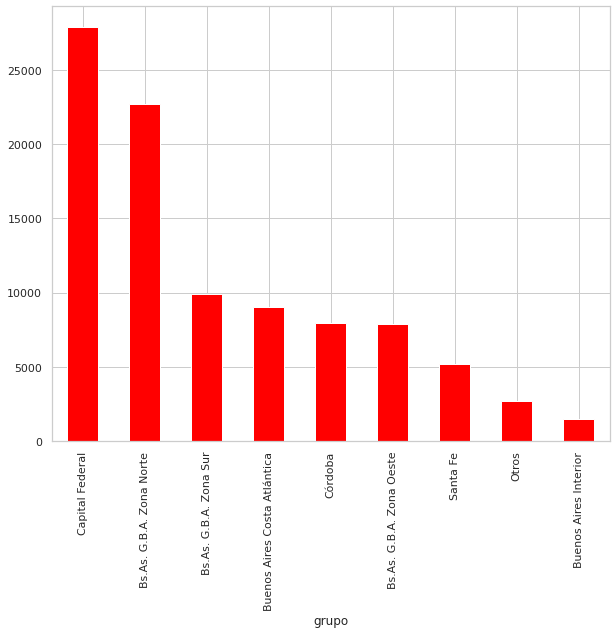

In [26]:
observaciones.plot(kind='bar', color='red')

In [27]:
#Variables con escala logaritmica para los precios
data['precio_ars_log']    = np.log(data['precio_ars'] + 1)
data['precio_m2_ars_log'] = np.log(data['precio_m2_ars'] + 1)
data['precio_usd_log']    = np.log(data['precio_usd'] + 1)
data['precio_m2_usd_log'] = np.log(data['precio_m2_usd'] + 1)

## Aplicacion de distancias al subte

Advertencia: por ahora, solo lo calculamos para x cantidad de registros debido al tiempo de proceso.

In [28]:
def haversine(Olat,Olon, Dlat,Dlon):

    radius = 6371.  # km

    d_lat = np.radians(Dlat - Olat)
    d_lon = np.radians(Dlon - Olon)
    a = (np.sin(d_lat / 2.) * np.sin(d_lat / 2.) +
         np.cos(np.radians(Olat)) * np.cos(np.radians(Dlat)) *
         np.sin(d_lon / 2.) * np.sin(d_lon / 2.))
    c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1. - a))
    d = radius * c
    return d

def searchClosestSubDistance(dataSubte,lat,long):
    dataSubte['dist'] = dataSubte.apply(lambda x: haversine(x['lat'], x['long'],lat,long), axis=1)
    return dataSubte['dist'].min() #dist

In [29]:
mask = ((pd.notnull(data.lat)) & (pd.notnull(data.lng)) & (data.grupo == 'Capital Federal')) 
data2 = data[mask].head(5000)
print("Se usarán 5000 registros de {0} en el Grupo Capital Federal".format(len(data[mask])))

Se usarán 5000 registros de 27519 en el Grupo Capital Federal


In [30]:
data2['dist'] = data2.apply(lambda x:  searchClosestSubDistance(subtes, x['lat'], x['lng']), axis=1)
data2.head(5)

,id,op,tipo,pais,estado,localidad,geoid,lat,lng,precio_usd,...,cochera,patio,piscina,amenities,grupo,precio_ars_log,precio_m2_ars_log,precio_usd_log,precio_m2_usd_log,dist
3577.0,0,sell,PH,Argentina,Capital Federal,Mataderos,3430787.0,-34.661824,-58.508839,62000.0,...,0,1,0,1,Capital Federal,13.905315,7.346655,11.034906,7.028443,4.781915
3577.0,2,sell,apartment,Argentina,Capital Federal,Mataderos,3430787.0,-34.652262,-58.522982,72000.0,...,0,0,0,0,Capital Federal,14.054846,7.177852,11.184435,7.177852,5.436760
4122.0,3,sell,PH,Argentina,Capital Federal,Liniers,3431333.0,-34.647797,-58.516424,95000.0,...,0,1,0,1,Capital Federal,14.332057,NaN,11.461643,NaN,4.683008
8852.0,7,sell,apartment,Argentina,Capital Federal,Belgrano,3436077.0,-34.559873,-58.443362,138000.0,...,0,0,0,0,Capital Federal,14.705433,8.146419,11.835016,8.028673,1.068329
8852.0,8,sell,apartment,Argentina,Capital Federal,Belgrano,3436077.0,-34.559873,-58.443362,195000.0,...,0,0,0,0,Capital Federal,15.051179,8.086718,12.180760,8.006701,1.068329


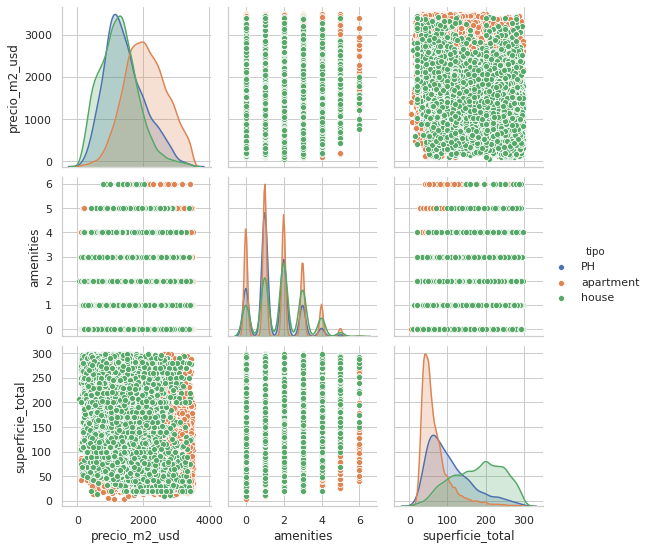

In [31]:
#intento de encontar correlacion entre el precio del metro cuadrado y otras variables
mask_graph = (data.precio_m2_usd < 3500) & (data.superficie_total < 300) & (data.tipo != 'store')
sns.pairplot(data[mask_graph], vars = ['precio_m2_usd','amenities','superficie_total'], hue='tipo',height=2.5)

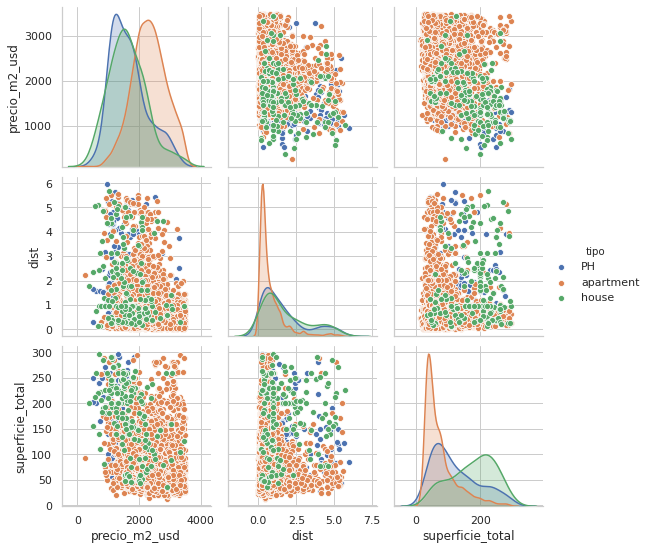

In [32]:
mask_graph = (data2['precio_m2_usd'] < 3500) & (data2['superficie_total'] < 300) & (data2['tipo'] != 'store')
sns.pairplot(data2[mask_graph], vars = ['precio_m2_usd','dist','superficie_total'], hue='tipo',height=2.5)

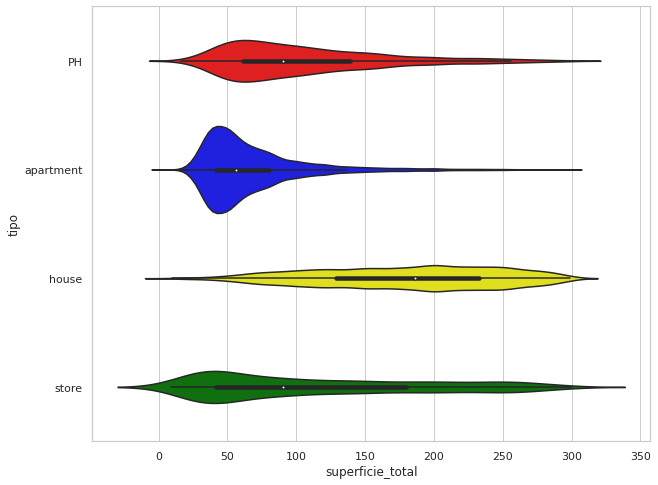

In [33]:
mask_graph = (data.precio_m2_usd < 3500) & (data.superficie_total < 300) 
palette_col = ["red", "blue", "yellow", "green"]
sns.violinplot("superficie_total", "tipo", data=data[mask_graph], palette = palette_col)

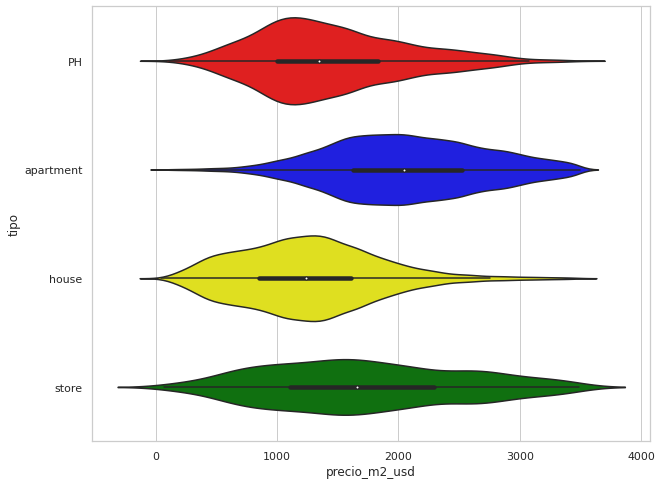

In [34]:
sns.violinplot("precio_m2_usd", "tipo", data=data[mask_graph], palette = palette_col)

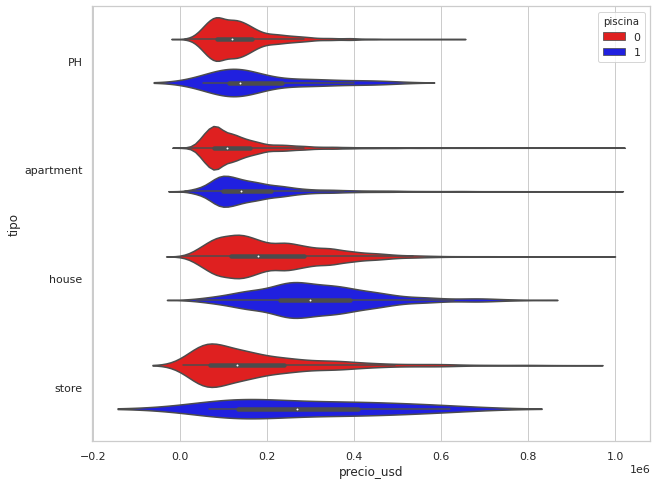

In [35]:
sns.violinplot("precio_usd", "tipo", hue="piscina",
               data=data[mask_graph], palette = palette_col,
               title='distribución precio total en funcion de superficie')

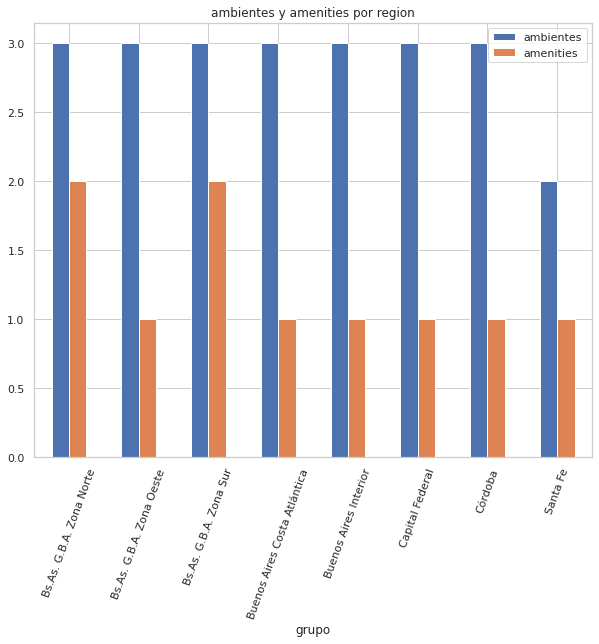

In [36]:
data_group_state = data.groupby('grupo')
media_state = data_group_state.median()
ciudades = ['Bs.As. G.B.A. Zona Norte',
            'Bs.As. G.B.A. Zona Oeste',
            'Bs.As. G.B.A. Zona Sur',
            'Buenos Aires Costa Atlántica',
            'Buenos Aires Interior',
           'Capital Federal',
           'Córdoba',
           'Santa Fe']
media_state_filt = media_state.loc[media_state.index.isin(ciudades)]
media_state_filt.plot.bar(rot=70 ,y=['ambientes','amenities'], title ="ambientes y amenities por region")

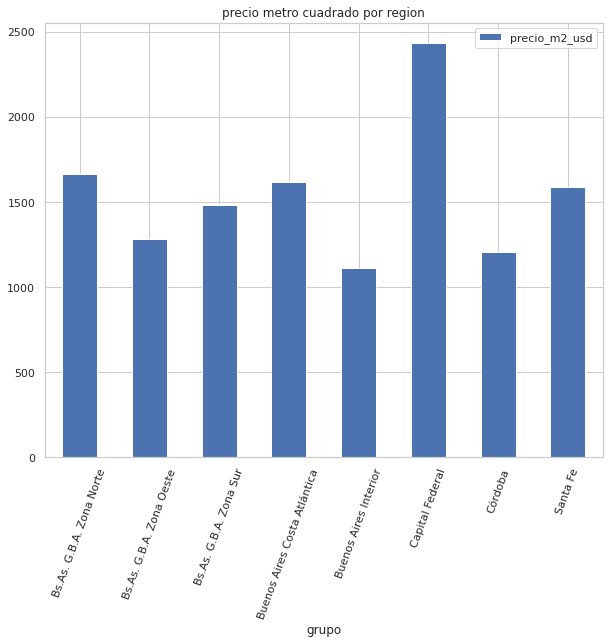

In [37]:
media_state_filt.plot.bar(rot=70 ,y="precio_m2_usd", title="precio metro cuadrado por region")

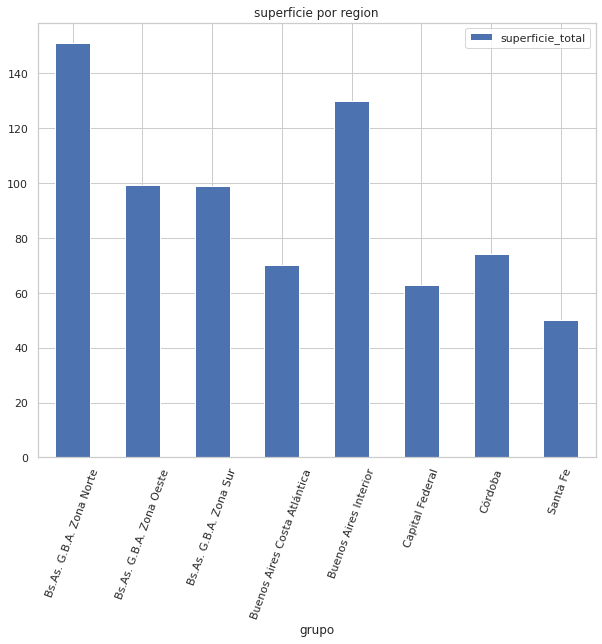

In [38]:
media_state_filt.plot.bar(rot=70 ,y="superficie_total", title="superficie por region")

Text(0.5, 1.0, 'Propiedades en venta por Grupo/Región')

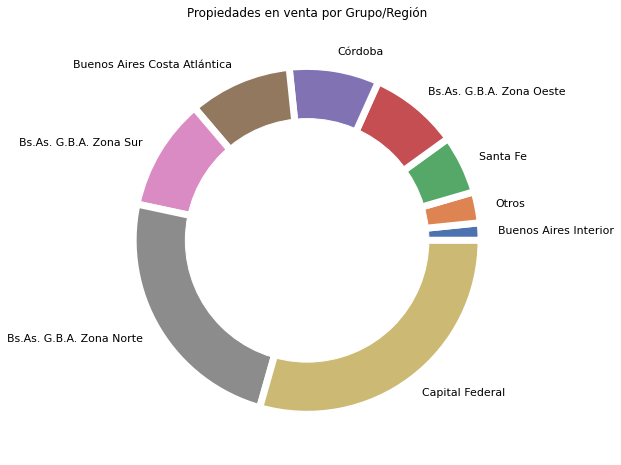

In [41]:
from palettable.colorbrewer.qualitative import Set1_7

regiones     = pd.Series(data['grupo'].value_counts().sort_values(ascending=True))
region_graph = pd.DataFrame(regiones)
region_graph['Cantidad'] = region_graph['grupo']
region_graph = region_graph.drop(labels='grupo', axis=1)

names = region_graph.index

fig = plt.figure()
fig.patch.set_facecolor("white")
plt.rcParams["text.color"] = "black"

my_circle=plt.Circle( (0,0), 0.7, color="white")
plt.pie(region_graph["Cantidad"], labels=names,
        wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' },
        colors=Set1_7.hex_colors)

my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Propiedades en venta por Grupo/Región")